# Exploring Interesting Aspects of EEGPT Model

This notebook explores various interesting aspects of the EEGPT (EEG Pre-trained Transformer) model, including its architecture, learned representations, attention patterns, and performance insights.

## 1. Import Required Libraries

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.manifold import TSNE
import pandas as pd

# Import project modules
# import sys
# sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname(__file__), '..')))

from src.models.EEGPT import EEGPTClassifier
from src.data.dataset import EEGDataset
from src.data.datamodule import EEGDataModule
from src.utils.preprocessing import apply_preprocessing

# Set style
plt.style.use('default')
sns.set_palette("husl")

## 2. Load Trained EEGPT Model

In [6]:
# Load model configuration
import yaml
with open('configs/model/eegpt.yaml', 'r') as f:
    model_config = yaml.safe_load(f)

# Load preprocessing config first to get channels
with open('configs/preprocessing/eegpt_frontal_central.yaml', 'r') as f:
    preprocessing_config = yaml.safe_load(f)

# Create a temporary dataset to get electrode names
temp_dataset = EEGDataset(
    data_dir='../eeg-classification/data/raw/09_25_256hz',
    task='free_instructed',
    preprocessing_config=preprocessing_config
)
electrode_names = temp_dataset.electrode_names.tolist()

# Model parameters
num_classes = 2  # For free_instructed task
in_channels = len(electrode_names)  # After channel selection
img_size = [len(electrode_names), 256]  # Based on preprocessing

# Create model
model = EEGPTClassifier(
    num_classes=num_classes,
    in_channels=in_channels,
    img_size=img_size,
    use_channels_names=electrode_names,
    **model_config['eegpt']
)

# Load checkpoint if available
checkpoint_path = 'checkpoints/best_model_free_instructed.pt'  # Assuming it exists
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint)
    print("Loaded trained model from checkpoint")
else:
    print("No checkpoint found, using randomly initialized model")

# load encoder
pretrain_ckpt = torch.load("/ems/elsc-labs/kadmon-j/gilad.ticher/eeg-classification/checkpoints/eegpt_mcae_58chs_4s_large4E.ckpt")
target_encoder_state = {}
for k, v in pretrain_ckpt['state_dict'].items():
    if k.startswith("target_encoder."):
        target_encoder_state[k[15:]] = v 
model.target_encoder.load_state_dict(target_encoder_state, strict=False)

model.eval()
print(f"Model loaded with {sum(p.numel() for p in model.parameters()):,} parameters")

Loaded trained model from checkpoint
Model loaded with 50,838,776 parameters


## 3. Load and Prepare Test Data

In [7]:
# # Load preprocessing config
# with open('configs/preprocessing/eegpt_frontal_central.yaml', 'r') as f:
#     preprocessing_config = yaml.safe_load(f)

# # Create dataset
# data_dir = '../eeg-classification/data/raw/09_25_256hz'
# dataset = EEGDataset(
#     data_dir=data_dir,
#     task='free_instructed',
#     preprocessing_config=preprocessing_config
# )

# Create a small subset for analysis
subset_size = 1000
indices = np.random.choice(len(temp_dataset), subset_size, replace=False)
subset_data = []
subset_labels = []

for idx in indices:
    data, label = temp_dataset[idx]
    subset_data.append(data)
    subset_labels.append(label)

subset_data = torch.stack(subset_data)
subset_labels = torch.tensor(subset_labels)

print(f"Loaded subset of {subset_size} samples")
print(f"Data shape: {subset_data.shape}")
print(f"Number of classes: {len(torch.unique(subset_labels))}")

Loaded subset of 1000 samples
Data shape: torch.Size([1000, 34, 256])
Number of classes: 2


## 4. Model Predictions and Performance Analysis

Model accuracy on subset: 0.6450


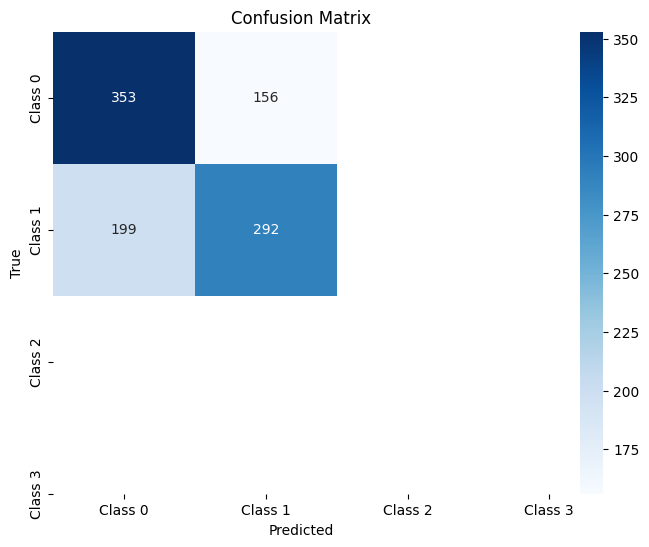


Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.69      0.67       509
           1       0.65      0.59      0.62       491

    accuracy                           0.65      1000
   macro avg       0.65      0.64      0.64      1000
weighted avg       0.65      0.65      0.64      1000



In [8]:
# Make predictions
with torch.no_grad():
    outputs = model(subset_data)
    predictions = torch.argmax(outputs, dim=1)
    probabilities = torch.softmax(outputs, dim=1)

# Calculate accuracy
accuracy = (predictions == subset_labels).float().mean().item()
print(f"Model accuracy on subset: {accuracy:.4f}")

# Confusion matrix
cm = confusion_matrix(subset_labels.numpy(), predictions.numpy())
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'],
            yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(subset_labels.numpy(), predictions.numpy()))

## 5. Extract and Visualize Learned Representations

Feature shape: torch.Size([500, 512])


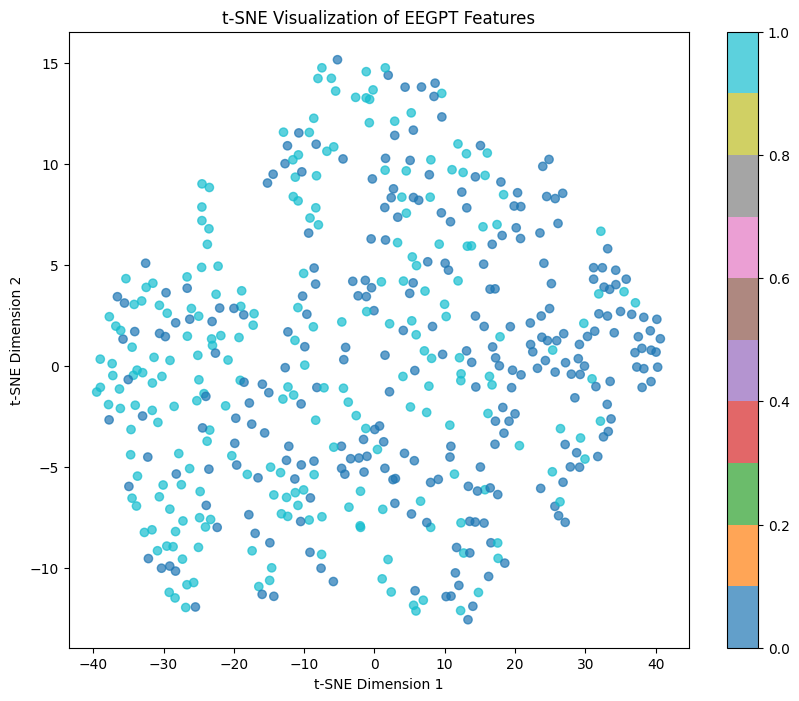

In [9]:
# Extract features from the model (before classification head)
class FeatureExtractor(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        # Remove the classification head
        self.feature_extractor = nn.Sequential(*list(model.children())[:-1])
    
    def forward(self, x):
        # Get features before the final classification layer
        with torch.no_grad():
            features = self.model.forward_features(x)
        return features

feature_extractor = FeatureExtractor(model)

# Extract features for a smaller subset
small_subset_size = 500
small_indices = np.random.choice(len(subset_data), small_subset_size, replace=False)
small_data = subset_data[small_indices]
small_labels = subset_labels[small_indices]

features = feature_extractor(small_data)
print(f"Feature shape: {features.shape}")

# Flatten features for t-SNE
features_flat = features.view(features.size(0), -1).numpy()

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
features_2d = tsne.fit_transform(features_flat)

# Plot t-SNE
plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], 
                     c=small_labels.numpy(), cmap='tab10', alpha=0.7)
plt.colorbar(scatter)
plt.title('t-SNE Visualization of EEGPT Features')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

## 6. Analyze Channel Importance

In [ ]:
# Analyze channel importance using occlusion sensitivity
def occlusion_sensitivity(model, data, target_class, channel_idx):
    """Compute how much accuracy drops when occluding a specific channel"""
    original_pred = model(data).argmax(dim=1)
    original_acc = (original_pred == target_class).float().mean()
    
    # Occlude channel by setting to zero
    occluded_data = data.clone()
    occluded_data[:, channel_idx, :] = 0
    
    occluded_pred = model(occluded_data).argmax(dim=1)
    occluded_acc = (occluded_pred == target_class).float().mean()
    
    return original_acc - occluded_acc

# Test on a small batch
test_batch_size = 50
test_indices = np.random.choice(len(subset_data), test_batch_size, replace=False)
test_data = subset_data[test_indices]
test_labels = subset_labels[test_indices]

channel_importance = []
channel_names = preprocessing_config['select_channels']['channels']

for i, channel in enumerate(channel_names):
    importance = occlusion_sensitivity(model, test_data, test_labels, i).item()
    channel_importance.append((channel, importance))

# Sort by importance
channel_importance.sort(key=lambda x: x[1], reverse=True)

# Plot
channels, importances = zip(*channel_importance)
plt.figure(figsize=(12, 6))
plt.bar(range(len(channels)), importances)
plt.xticks(range(len(channels)), channels, rotation=45, ha='right')
plt.title('Channel Importance (Occlusion Sensitivity)')
plt.xlabel('EEG Channel')
plt.ylabel('Accuracy Drop')
plt.tight_layout()
plt.show()

print("Top 5 most important channels:")
for channel, imp in channel_importance[:5]:
    print(f"{channel}: {imp:.4f}")

## 7. Model Architecture Analysis

In [ ]:
# Analyze model architecture
print("Model Architecture Summary:")
print(model)

# Count parameters by layer
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

def count_parameters_by_layer(model):
    layer_params = {}
    for name, module in model.named_modules():
        if len(list(module.parameters())) > 0 and not list(module.children()):
            layer_params[name] = sum(p.numel() for p in module.parameters())
    return layer_params

total_params = count_parameters(model)
layer_params = count_parameters_by_layer(model)

print(f"\nTotal parameters: {total_params:,}")
print("\nParameters by layer:")
for layer, params in sorted(layer_params.items(), key=lambda x: x[1], reverse=True):
    print(f"{layer}: {params:,} ({100*params/total_params:.1f}%)")

# Visualize parameter distribution
plt.figure(figsize=(10, 6))
layers = list(layer_params.keys())
params = list(layer_params.values())
plt.barh(range(len(layers)), params)
plt.yticks(range(len(layers)), layers)
plt.xlabel('Number of Parameters')
plt.title('Parameter Distribution by Layer')
plt.tight_layout()
plt.show()